In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import root_mean_squared_error
import pickle
from prepare_data import PrepareData

c:\Users\krist\work\university\year2\semester2\data analysis\final-model\training\prepare_data.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("6H")


In [2]:
df = PrepareData.df
train_data = PrepareData.train_data()
test_data = PrepareData.test_data()

Fill the missing value with the previous data from the role.

In [3]:
train_data.columns

Index(['id', 'light', 'temperature', 'soil_moisture', 'humidity', 'api_temp',
       'precipitation', 'cloud_cover'],
      dtype='object')

In [4]:
for column in train_data.columns:
    print(column)
    if column == 'id':
        continue
    train_data[column] = train_data[column].ffill()
    test_data[column] = test_data[column].ffill()

id
light
temperature
soil_moisture
humidity
api_temp
precipitation
cloud_cover


C:\Users\krist\AppData\Local\Temp\ipykernel_22348\2442158754.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = train_data[column].ffill()
C:\Users\krist\AppData\Local\Temp\ipykernel_22348\2442158754.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[column] = test_data[column].ffill()


# EDA

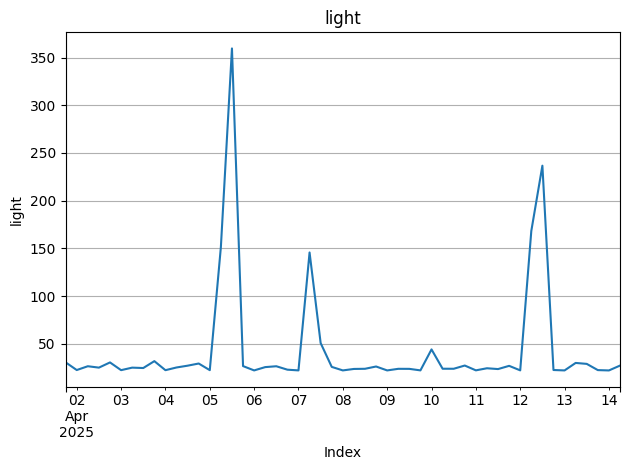

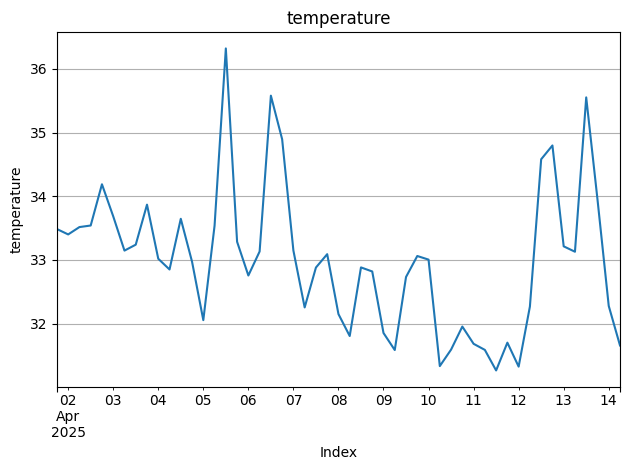

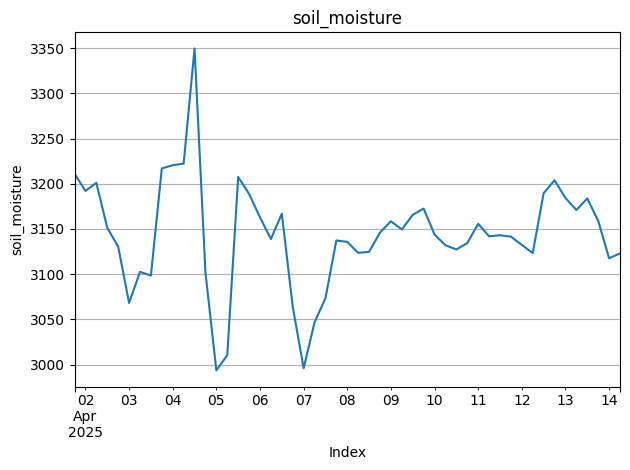

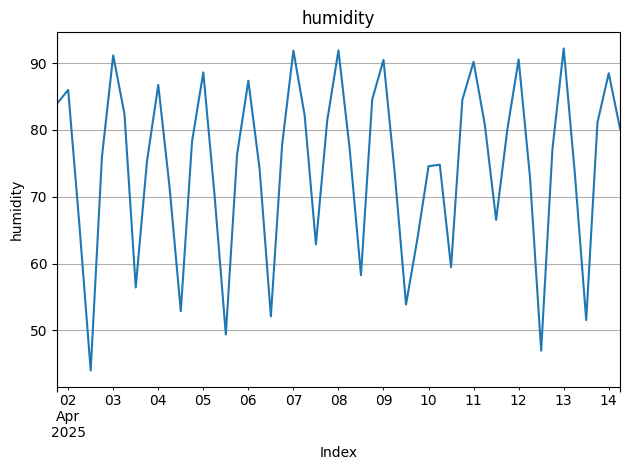

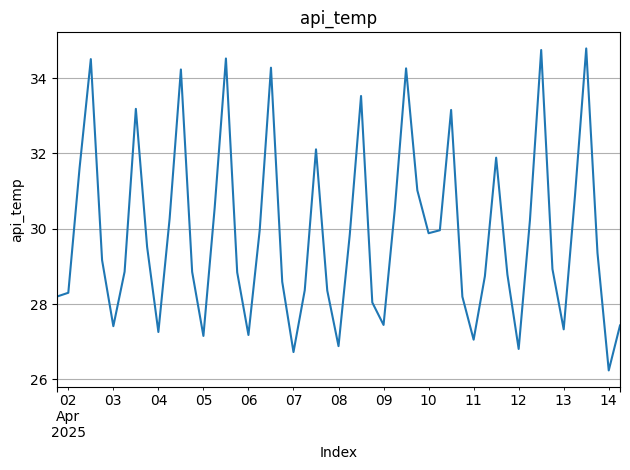

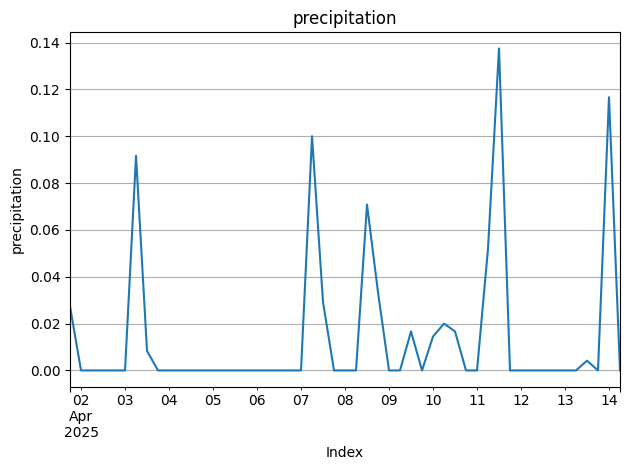

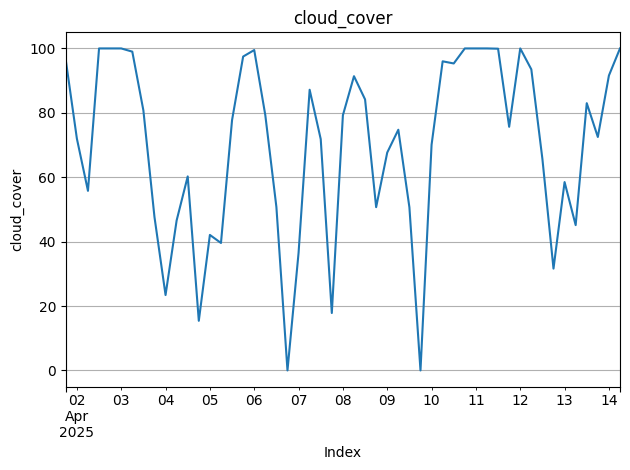

In [5]:
for column in df.columns:
    if column == "id":
        continue
    plt.figure()  # Create a new figure for each plot
    df[column].plot()
    plt.title(column)
    plt.xlabel("Index")  # or "Date" if it's time series
    plt.ylabel(column)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

<Axes: >

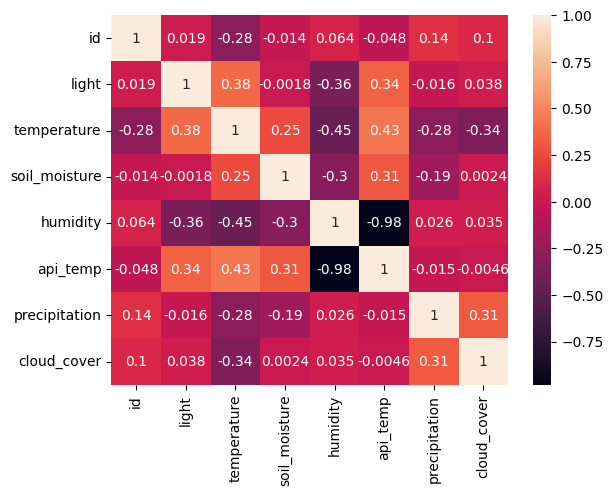

In [6]:
sns.heatmap(df.corr(),annot=True)

## Find D parameter

We'll use adfuller test.

In [7]:
data = df["soil_moisture"].dropna()
diff = 0
while True:
    result = adfuller(data)
    if result[1] < 0.05 or result[0] < result[4]["5%"]:
        print(f"d={diff}")
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        for key, value in result[4].items():
            print('Critial Values:')
            print(f'   {key}, {value}')
        break
    data = data.diff().dropna()
    diff+=1

d=0
ADF Statistic: -3.763705925303399
p-value: 0.0033012607223507876
Critial Values:
   1%, -3.610399601308181
Critial Values:
   5%, -2.939108945868946
Critial Values:
   10%, -2.6080629651545038


Therefore, d=1.

In [8]:
print(f"The diff value is {diff}")

The diff value is 0


## Find P parameter

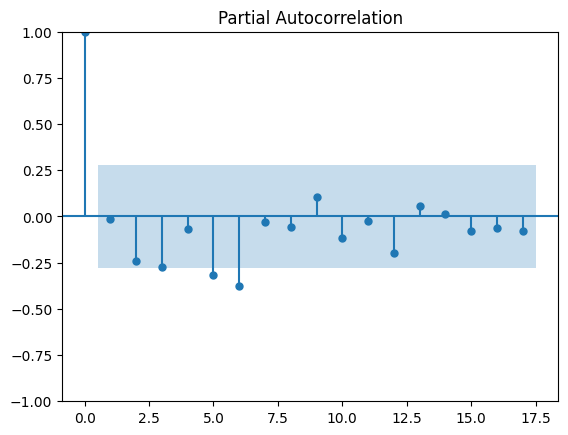

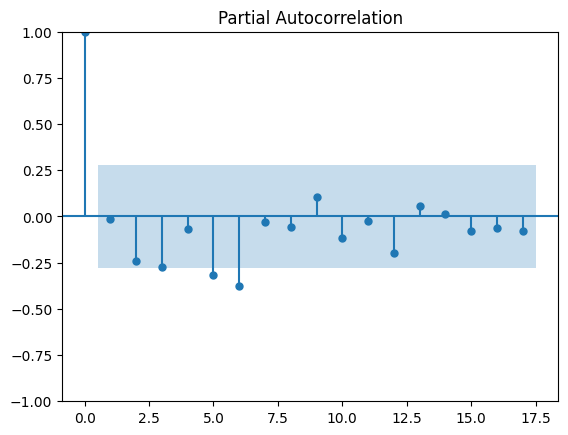

In [9]:
plot_pacf(df["soil_moisture"].diff().dropna())


There are 1 exceptionally high bars, therefore, p=1

## Find Q parameter

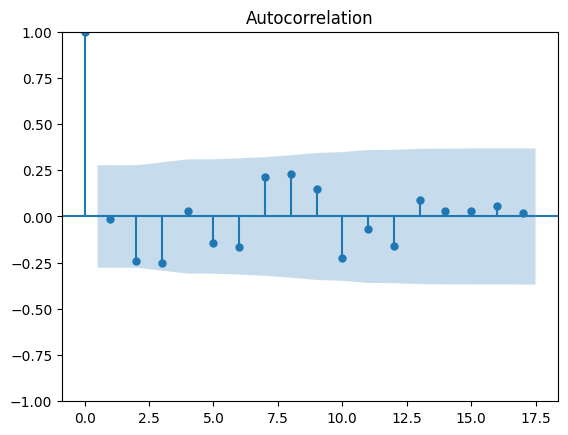

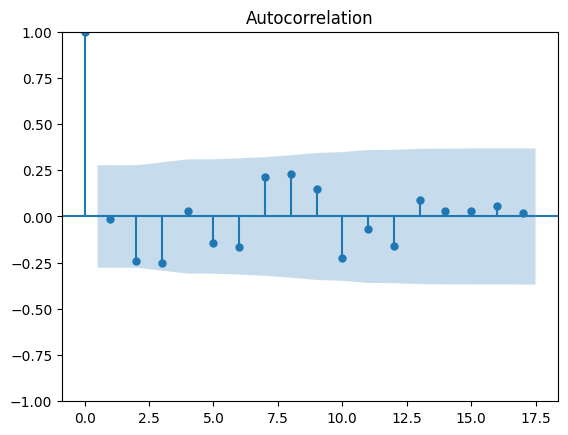

In [10]:
plot_acf(df["soil_moisture"].diff().dropna())

There are 1 exceptionally high bars, therefore, q=1

# Pre-Processing

In [11]:
train_data.head()

id      light  temperature  soil_moisture   humidity  \
ts                                                                            
2025-04-01 18:00:00   6.0  30.485055    33.485800    3211.045455  83.909091   
2025-04-02 00:00:00  13.0  22.453833    33.401067    3192.000000  86.000000   
2025-04-02 06:00:00  23.5  26.436983    33.516494    3200.916667  65.722222   
2025-04-02 12:00:00  44.5  24.979783    33.541017    3151.187500  44.000000   
2025-04-02 18:00:00  68.5  30.427021    34.188162    3130.416667  76.000000   

                      api_temp  precipitation  cloud_cover  
ts                                                          
2025-04-01 18:00:00  28.200000       0.027273    96.363636  
2025-04-02 00:00:00  28.300000       0.000000    72.000000  
2025-04-02 06:00:00  31.611111       0.000000    55.777778  
2025-04-02 12:00:00  34.504167       0.000000   100.000000  
2025-04-02 18:00:00  29.166667       0.000000   100.000000

In [12]:
test_data.head()

id      light  temperature  soil_moisture  humidity  \
ts                                                                             
2025-04-09 00:00:00  662.50  22.044396    31.854167    3158.416667  90.50000   
2025-04-09 06:00:00  686.50  23.729654    31.586587    3149.458333  73.50000   
2025-04-09 12:00:00  710.50  23.680588    32.733071    3165.520833  53.87500   
2025-04-09 18:00:00  725.00  22.092880    33.062520    3172.500000  63.60000   
2025-04-10 00:00:00  550.06  44.067475    33.005682    3143.779905  74.57946   

                      api_temp  precipitation  cloud_cover  
ts                                                          
2025-04-09 00:00:00  27.445833       0.000000    67.666667  
2025-04-09 06:00:00  30.525000       0.000000    74.750000  
2025-04-09 12:00:00  34.258333       0.016667    50.666667  
2025-04-09 18:00:00  31.020000       0.000000     0.000000  
2025-04-10 00:00:00  29.880925       0.014485    70.079753

In [13]:
train_data[["soil_moisture"]]

soil_moisture
ts                                
2025-04-01 18:00:00    3211.045455
2025-04-02 00:00:00    3192.000000
2025-04-02 06:00:00    3200.916667
2025-04-02 12:00:00    3151.187500
2025-04-02 18:00:00    3130.416667
2025-04-03 00:00:00    3068.083333
2025-04-03 06:00:00    3102.520833
2025-04-03 12:00:00    3098.395833
2025-04-03 18:00:00    3216.895833
2025-04-04 00:00:00    3220.458333
2025-04-04 06:00:00    3222.208333
2025-04-04 12:00:00    3349.645833
2025-04-04 18:00:00    3101.583333
2025-04-05 00:00:00    2993.437500
2025-04-05 06:00:00    3010.354167
2025-04-05 12:00:00    3207.479167
2025-04-05 18:00:00    3188.673913
2025-04-06 00:00:00    3162.833333
2025-04-06 06:00:00    3138.795455
2025-04-06 12:00:00    3166.785714
2025-04-06 18:00:00    3064.041667
2025-04-07 00:00:00    2995.875000
2025-04-07 06:00:00    3046.555417
2025-04-07 12:00:00    3073.291667
2025-04-07 18:00:00    3137.187500
2025-04-08 00:00:00    3135.625000
2025-04-08 06:00:00    3123.541667
2025-04-08 12:00:00    3124.625000
2025-04-08 18:00:00    3145.979167

In [14]:
test_data['soil_moisture'].count()

9

In [15]:
test_data[['light', 'precipitation']]

light  precipitation
ts                                           
2025-04-09 00:00:00  22.044396       0.000000
2025-04-09 06:00:00  23.729654       0.000000
2025-04-09 12:00:00  23.680588       0.016667
2025-04-09 18:00:00  22.092880       0.000000
2025-04-10 00:00:00  44.067475       0.014485
2025-04-10 06:00:00  23.824460       0.020000
2025-04-10 12:00:00  23.791867       0.016667
2025-04-10 18:00:00  27.169396       0.000000
2025-04-11 00:00:00  22.121229       0.000000

# Train the model

Import the model to predict the exog values

In [16]:
# Import exog data predicting models 
with open('../exports/api_temp_sarima.pkl', 'rb') as file:
    api_temp_model = pickle.load(file)

with open('../exports/humidity_sarima.pkl', 'rb') as file:
    humidity_model = pickle.load(file)

with open('../exports/temperature_sarima.pkl', 'rb') as file:
    temperature_model = pickle.load(file)
    
with open('../exports/light_sarima.pkl', 'rb') as file:
    light_model = pickle.load(file)
    
with open('../exports/precipitation_sarima.pkl', 'rb') as file:
    precipitation_model = pickle.load(file)

In [17]:
light_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             light   No. Observations:                   26
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 3)   Log Likelihood                -148.988
Date:                           Wed, 30 Apr 2025   AIC                            307.976
Time:                                   00:13:40   BIC                            314.266
Sample:                               04-01-2025   HQIC                           309.787
                                    - 04-08-2025                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1582      1.443      0.110      0.913      -2.670       2.986
ma.L1          0.2515      1.620      0.155      0.877      -2.924       3.428
ar.S.L3        0.9998      0.039     25.762      0.000       0.924       1.076
ma.S.L3       -0.9927      0.712     -1.395      0.163      -2.388       0.402
sigma2      5100.2459      0.000   3.66e+07      0.000    5100.246    5100.246
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                66.86
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               8.39   Skew:                             2.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.25e+24. Standard errors may be unstable.
"""

In [18]:
# Predicting the data
forecast_steps = len(test_data)

# Get forecasts and rename columns immediately
exog_predictions = (
    precipitation_model.get_forecast(steps=forecast_steps)
    .predicted_mean
    .rename('precipitation')
    .to_frame()
)

light_predictions = (
    light_model.get_forecast(steps=forecast_steps)
    .predicted_mean
    .rename('light')
    .to_frame()
)

# Combine exogenous variables
exog_predictions = pd.concat(
    [exog_predictions, light_predictions], 
    axis=1
)

print(exog_predictions.columns)
print(test_data[['light', 'precipitation']])
exog_predictions.head()

Index(['precipitation', 'light'], dtype='object')
                         light  precipitation
ts                                           
2025-04-09 00:00:00  22.044396       0.000000
2025-04-09 06:00:00  23.729654       0.000000
2025-04-09 12:00:00  23.680588       0.016667
2025-04-09 18:00:00  22.092880       0.000000
2025-04-10 00:00:00  44.067475       0.014485
2025-04-10 06:00:00  23.824460       0.020000
2025-04-10 12:00:00  23.791867       0.016667
2025-04-10 18:00:00  27.169396       0.000000
2025-04-11 00:00:00  22.121229       0.000000


precipitation      light
2025-04-08 06:00:00       0.036734  23.784553
2025-04-08 12:00:00       0.010834  33.899941
2025-04-08 18:00:00       0.008534  20.639280
2025-04-09 00:00:00       0.004791  22.474972
2025-04-09 06:00:00       0.037796  33.686628

In [19]:
print("Training exog stats:")
print(train_data[['precipitation', 'light']].describe())

print("\nPrediction exog stats:")
print(exog_predictions.describe())

Training exog stats:
       precipitation       light
count      29.000000   29.000000
mean        0.012435   46.154697
std         0.027846   68.217075
min         0.000000   22.052842
25%         0.000000   22.825450
50%         0.000000   25.523759
75%         0.000000   29.284550
max         0.100000  359.524546

Prediction exog stats:
       precipitation      light
count       9.000000   9.000000
mean        0.018322  25.758879
std         0.014781   6.091149
min         0.004791  20.598045
25%         0.008534  20.639280
50%         0.010834  22.474972
75%         0.036734  33.678893
max         0.038859  33.899941


## Pre-Processing

In [20]:
train_data["soil_moisture"] = train_data["soil_moisture"].ffill()
test_data["soil_moisture"] = test_data["soil_moisture"].ffill()

C:\Users\krist\AppData\Local\Temp\ipykernel_22348\1675882355.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["soil_moisture"] = train_data["soil_moisture"].ffill()
C:\Users\krist\AppData\Local\Temp\ipykernel_22348\1675882355.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["soil_moisture"] = test_data["soil_moisture"].ffill()


## Actual Prediction

In [21]:
train_data['soil_moisture']

ts
2025-04-01 18:00:00    3211.045455
2025-04-02 00:00:00    3192.000000
2025-04-02 06:00:00    3200.916667
2025-04-02 12:00:00    3151.187500
2025-04-02 18:00:00    3130.416667
2025-04-03 00:00:00    3068.083333
2025-04-03 06:00:00    3102.520833
2025-04-03 12:00:00    3098.395833
2025-04-03 18:00:00    3216.895833
2025-04-04 00:00:00    3220.458333
2025-04-04 06:00:00    3222.208333
2025-04-04 12:00:00    3349.645833
2025-04-04 18:00:00    3101.583333
2025-04-05 00:00:00    2993.437500
2025-04-05 06:00:00    3010.354167
2025-04-05 12:00:00    3207.479167
2025-04-05 18:00:00    3188.673913
2025-04-06 00:00:00    3162.833333
2025-04-06 06:00:00    3138.795455
2025-04-06 12:00:00    3166.785714
2025-04-06 18:00:00    3064.041667
2025-04-07 00:00:00    2995.875000
2025-04-07 06:00:00    3046.555417
2025-04-07 12:00:00    3073.291667
2025-04-07 18:00:00    3137.187500
2025-04-08 00:00:00    3135.625000
2025-04-08 06:00:00    3123.541667
2025-04-08 12:00:00    3124.625000
2025-04-08 18:00:

In [22]:
model = SARIMAX(
    endog=train_data['soil_moisture'],
    exog=train_data[['precipitation', 'light']],
    order=(0, 1, 0)
)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          soil_moisture   No. Observations:                   29
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -160.982
Date:                Wed, 30 Apr 2025   AIC                            327.963
Time:                        00:13:40   BIC                            331.960
Sample:                    04-01-2025   HQIC                           329.185
                         - 04-08-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
precipitation   -53.5189    974.159     -0.055      0.956   -1962.834    1855.797
light             0.2814      0.152      1.847      0.065      -0.017       0.580
sigma2         5772.2331   1065.481      5.417      0.000    3683.930    7860.537
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 8.95
Prob(Q):                              0.76   Prob(JB):                         0.01
Heteroskedasticity (H):               1.06   Skew:                            -0.82
Prob(H) (two-sided):                  0.94   Kurtosis:                         5.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
steps = int(test_data['soil_moisture'].count())
prediction = results.get_forecast(steps=steps , exog=exog_predictions[['precipitation', 'light']].iloc[:steps]).predicted_mean
prediction.columns = ['predicted']
prediction

2025-04-09 00:00:00    3145.129441
2025-04-09 06:00:00    3149.362265
2025-04-09 12:00:00    3145.753476
2025-04-09 18:00:00    3146.470446
2025-04-10 00:00:00    3147.859265
2025-04-10 06:00:00    3145.563157
2025-04-10 12:00:00    3146.210473
2025-04-10 18:00:00    3149.566641
2025-04-11 00:00:00    3144.118961
Freq: 6h, Name: predicted_mean, dtype: float64

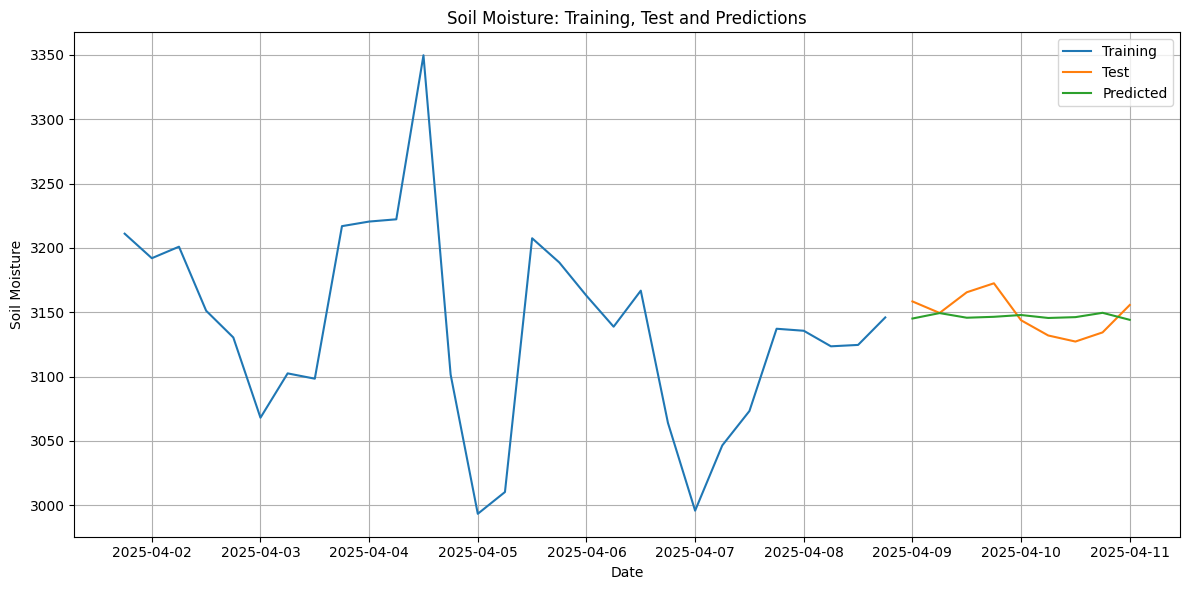

RMSE :  15.529872817391373


In [24]:
plt.figure(figsize=(12, 6))
# Ensure datetime index and proper plotting
plt.plot(train_data.index, train_data["soil_moisture"], label="Training")
plt.plot(test_data.index, test_data["soil_moisture"], label="Test")
plt.plot(test_data.index, prediction, label="Predicted")  # use the same x-axis as test

plt.legend()
plt.xlabel("Date")
plt.ylabel("Soil Moisture")
plt.title("Soil Moisture: Training, Test and Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()

print("RMSE : ", root_mean_squared_error(test_data['soil_moisture'], prediction))


## Exporting the trained model with Pickle for external uses.

**Warning** : Do not unpickle untrusted model because it might execute a malicious code hidden in the model file.

In [25]:
with open('../exports/plant_water.pkl', 'wb') as file:
    pickle.dump(results, file)